<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # get some random training images
images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [43]:
# @title model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, 6, 5),
            # nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear(x)
        return x

class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(),# nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 5, 1, 2), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 7, 1, 3), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            # nn.Linear(16 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(plane_list[2] * 8 * 8, 256), nn.ReLU(),
            # nn.Linear(plane_list[2]//16, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.view(-1, 16 * 5 * 5)
        x = nn.Flatten()(x)
        x = self.linear(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = ConvNet().to(device)
model = ConvNet1().to(device)
# print(model)

loss_list=[]



In [44]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")


torch.Size([64, 10])
tensor([-0.1594, -0.0608,  0.2353,  0.1490,  0.1327,  0.0215,  0.0503, -0.0042,
         0.0593, -0.0365], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted class: tensor([2, 2, 2, 8, 8, 2, 8, 4, 2, 2, 2, 4, 2, 2, 3, 2, 2, 8, 2, 2, 2, 2, 2, 2,
        2, 2, 4, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 4, 2, 2, 2, 2,
        2, 4, 2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [ ]:
# @title CNN test/train
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def train():
    model.train()
    num_epochs = 5
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader): # origin shape: [4, 3, 32, 32] = 4, 3, 1024 input_layer: 3 input channels, 6 output channels, 5 kernel size
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 2000 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

def test():
    model.eval()
    n_correct = 0
    n_samples = 0
    with torch.no_grad():
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')

# train()
# print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)
# test()

In [36]:
# @title train test function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        # loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


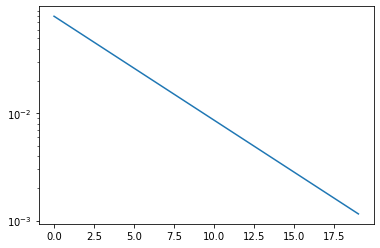

In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8) # 0.75(20)-0.9(100)
# gamma^step
lr_list=[]
for x in range(20):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    lr_list.append(lr)

import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()


In [45]:

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75) # 0.75(20)-0.9(100)
lr_list=[]

epochs = 20 #5 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    # print(lr)
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    scheduler.step()
print("Done!")
torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))


Epoch 1
-------------------------------
loss: 2.265012  [    0/50000]
loss: 2.098091  [ 8000/50000]
loss: 0.841960  [16000/50000]
loss: 1.260726  [24000/50000]
loss: 1.084588  [32000/50000]
loss: 1.041607  [40000/50000]
loss: 0.576263  [48000/50000]
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.066347 

Epoch 2
-------------------------------
loss: 1.595021  [    0/50000]
loss: 0.646188  [ 8000/50000]
loss: 1.064454  [16000/50000]
loss: 1.171420  [24000/50000]
loss: 0.746542  [32000/50000]
loss: 0.366259  [40000/50000]
loss: 0.176448  [48000/50000]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.800887 

Epoch 3
-------------------------------
loss: 0.401760  [    0/50000]
loss: 1.065860  [ 8000/50000]
loss: 1.343651  [16000/50000]
loss: 0.031683  [24000/50000]
loss: 0.030797  [32000/50000]
loss: 1.156926  [40000/50000]
loss: 0.003997  [48000/50000]
Test Error: 
 Accuracy: 74.4%, Avg loss: 0.736233 

Epoch 4
-------------------------------
loss: 1.226542  [    0/50000]
loss: 0.382098  [ 8000/5

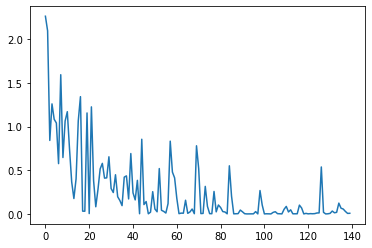

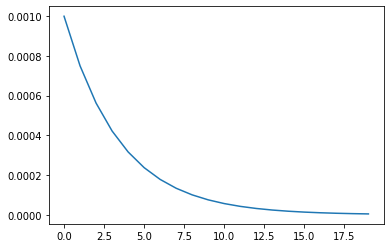

In [46]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
# plt.yscale('log')
plt.show()

plt.plot(lr_list)
plt.show()
